In [3]:
import re
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import string
from nltk.tokenize import TweetTokenizer#sentiment dict has possesive apostrophe, so we need a tokenizer that doesnt split on it
output_sentiment_length = 500

In [4]:
import sys
print (sys.version)

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]


In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shaul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from gutenberg.acquire import get_metadata_cache#took about an hour to run for me
cache = get_metadata_cache()
if not cache.exists:
    cache.populate()

In [7]:
def get_text(lines):
    tokens = []
    tokenizer = TweetTokenizer()
    for line in lines:
        #tokens += tokenizer.tokenize(line)
        #tokens += nltk.word_tokenize(line)
        tokens += line.split(' ')
    tokens = [token.strip(string.punctuation) for token in tokens if len(token)>1 or str.isalpha(token)]
    text = str.join(' ', tokens)
    return text.strip()

In [8]:
def filter_gutenberg(lines):# page 16
    success = True
    start = -1
    end = -1
    for i, line in enumerate(lines):
        start_location = max(line.find('START OF THIS PROJECT GUTENBERG EBOOK'), line.find('START OF THE PROJECT GUTENBERG EBOOK'))
        if start_location != -1:
            start = i+1
    if start == -1:
        for i, line in enumerate(lines[:int(len(lines) / 2)]):
            if line.find('END')!=-1 and line.find('SMALL PRINT') != -1:
                start = i+1
        if start == -1:
            success = False
            start = 0
    for i, line in enumerate(lines):
        end_location = max(line.find('END OF THIS PROJECT GUTENBERG EBOOK'), line.find('END OF THE PROJECT GUTENBERG EBOOK'), line.lower().find('end of project gutenberg'))
        if end_location != -1:
            end = i
            break
    if end == -1:
        for i, line in enumerate(lines[3*int((len(lines)+start)/4):]):
            if line.lower().find('end') != -1 and line.lower().find('project gutenberg') != -1:
                end = 3*int((len(lines) + start)/4) + i
        if end == -1:
            for i, line in enumerate(lines[9*int((len(lines)+start)/10):]):
                end_location = line.find('THE END')
                if end_location != -1:
                    end = int(9 * (len(lines) + start)/ 10) + i
            if end==-1:
                success = False
                end = len(lines)
    return True, lines[start:end]

In [9]:
def get_sentiment_dict():
    #regex = re.compile('[^a-zA-Z0-9 ]')
    with open('D:\\labmt_dataset.json') as data:
        json_obj = json.load(data)['objects']
    sentiment_dict = {}
    for i in range(len(json_obj)):
        word = json_obj[i]['word'].lower()
        sentiment_dict[word] = json_obj[i]['happs']
    return sentiment_dict

In [10]:
def hedonometer(sentiment_dict, text, output_length, sample_length, lense = None):
    not_detected = set()
    overlap = int((len(text) - sample_length-1)/output_length)
    if overlap < 1:
        print ("Not enough words to calculate sentiment: " + str(len(text)))
        raise AssertionError("Not enough words to calculate sentiment")
    sentiments = []
    word_count = 0
    sentiment_count = 0
    for word in text[:sample_length - overlap]:
        word = word.lower()
        if word in sentiment_dict:
            if lense is None or sentiment_dict[word] <lense[0] or sentiment_dict[word]>lense[1]:
                word_count += 1
                sentiment_count += sentiment_dict[word]
    for i in range(output_length):
        for j in range(((i - 1)*overlap + sample_length),(i * overlap + sample_length)):
            word = text[j].lower()
            if word in sentiment_dict:
                if lense is None or sentiment_dict[word] <lense[0] or sentiment_dict[word]>lense[1]:
                    word_count += 1
                    sentiment_count += sentiment_dict[word]
            else:
                not_detected.add(word)
        if word_count>0:
            sentiments.append(sentiment_count/word_count)
        else:
            if len(sentiments)>0:
                sentiments.append(sentiments[-1])
            else:
                sentiments.append(5)
        for j in range(i*overlap, (i+1)*overlap):
            word = text[j].lower()
            if word in sentiment_dict:
                if lense is None or sentiment_dict[word] <lense[0] or sentiment_dict[word]>lense[1]:
                    word_count -= 1
                    sentiment_count -= sentiment_dict[word]
    return sentiments

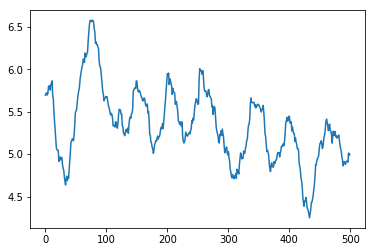

In [11]:
filename = 'D:/harrypotter.txt'
#filename = 'D:/university/NLP/ironman.txt'
with open(filename, 'r', encoding='windows-1252') as reader:
    lines = reader.readlines()

text = get_text(lines)
text = text.lower().split(' ')
sentiment_dict = get_sentiment_dict()
plt.plot(hedonometer(sentiment_dict, text, output_sentiment_length, 10000, [3,7]))
plt.show()

In [12]:
from gutenberg.query import list_supported_metadatas
from gutenberg.acquire import load_etext
from gutenberg.query import get_metadata

In [13]:
with open('D:\\university\\nlp\\bookids.txt') as id_reader:
    lines = id_reader.readlines()
    ids = [int(line) for line in lines]

In [14]:
class TextData:
    def __init__(self, name, sentiment, text):
        self.name = name
        self.sentiment = sentiment
        self.text = text

In [15]:
def get_gutenberg_text(id):
    try:
        lines = str.splitlines(load_etext(id))
    except:
        print ('text with id ' + str(id) + ' does not exist')
        return None
    success, filtered_lines = filter_gutenberg(lines)
    if not success:
        print("Failed to parse " + str(id))
    text =  get_text(filtered_lines).split(' ')
    return text

In [16]:
def get_gutenberg_texts(ids):
    sentiment_dict = get_sentiment_dict()
    textdata = {}
    disallowed_title_words = ['stories', 'collection', 'poems', 'complete', 'essays', 'fables', 'tales', 'papers', 'poetry', 'verses', 'ballads', 'sketches', 'vol.', 'vols.', 'works', 'volume', 'other']
    for id in ids:
        text = get_gutenberg_text(id)
        if text is None:
            continue
        title = 'temp'#list(get_metadata('title', id))[0]
        lowered_title = title.lower()
        valid_book = True
        for word in disallowed_title_words:
            if word in lowered_title:
                valid_book = False
                break
        if not valid_book:
            continue
        try:
            sentiment = np.array(hedonometer(sentiment_dict, text, output_sentiment_length, 10000, [3,7]))
            data = TextData(title, sentiment, text)
            textdata[id] = data
        except:
            print('failed at ' + str(id))
    return textdata
        
        

In [17]:
def plot_gutenberg_book(book_id):
    book_data = get_gutenberg_texts([book_id])[book_id]
    plt.plot(book_data.sentiment)
    plt.title(book_data.name)
    plt.show()

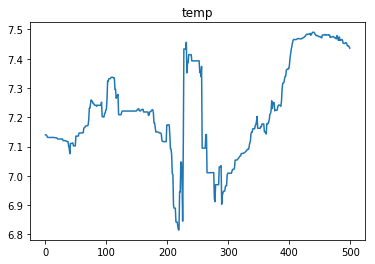

In [16]:
plot_gutenberg_book(16605)

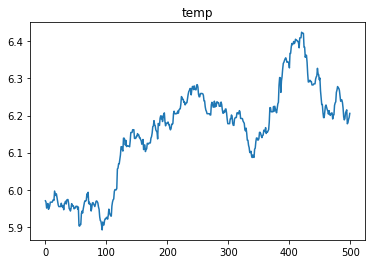

In [17]:
plot_gutenberg_book(11)

In [18]:
texts = get_gutenberg_texts(ids)

Not enough words to calculate sentiment: 9375
failed at 71
Not enough words to calculate sentiment: 8210
failed at 301
Not enough words to calculate sentiment: 8641
failed at 807
Not enough words to calculate sentiment: 7071
failed at 932
Not enough words to calculate sentiment: 7212
failed at 1034
Not enough words to calculate sentiment: 8975
failed at 1238
Not enough words to calculate sentiment: 9216
failed at 1642
Not enough words to calculate sentiment: 9454
failed at 2003
Not enough words to calculate sentiment: 8667
failed at 2344
Not enough words to calculate sentiment: 7315
failed at 2345
Not enough words to calculate sentiment: 7702
failed at 2348
Not enough words to calculate sentiment: 10005
failed at 2349
Not enough words to calculate sentiment: 9889
failed at 2373
Not enough words to calculate sentiment: 7258
failed at 3250
Not enough words to calculate sentiment: 7583
failed at 4507
text with id 5001 does not exist
Not enough words to calculate sentiment: 7075
failed at 

In [19]:
print(len(texts))

1641


In [18]:
import numpy as np
def svd_analysis(texts):
    input_matrix = np.array(texts)
    return np.linalg.svd(input_matrix, full_matrices = False)

In [19]:
order_mapping = dict(zip(texts.keys(), list(range(len(texts)))))
reverse_order_mapping = dict(zip(list(range(len(texts))), texts.keys()))
data = np.array([text.sentiment-np.mean(text.sentiment) for text in texts.values()])

NameError: name 'texts' is not defined

In [22]:
u, sigma, v = svd_analysis(data)
w= u * sigma # mode coefficients

In [20]:
def plot_svd_basis(v):
    fig, axes = plt.subplots(4, 3)
    for i in range(4):
        for j in range(3):
            index = 3*i+j
            axes[i, j].plot(v[index])
            axes[i,j].title.set_text('Mode ' + str(index+1))
    plt.tight_layout()
    plt.show()

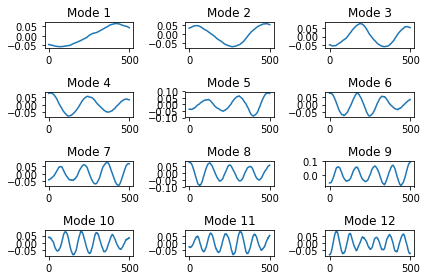

In [24]:
plot_svd_basis(v)

In [25]:
np.sum(sigma[:12]**2)/np.sum(sigma**2)#explained variance

0.9267692751887281

In [21]:
def nearest_neighbors(value, array, nbr_neighbors=1):#https://stackoverflow.com/questions/45742199/find-nearest-neighbors-of-a-numpy-array-in-list-of-numpy-arrays-using-euclidian
    return np.argsort(np.array([np.sum(np.abs(value-x)) for x in array]))[:nbr_neighbors]

In [22]:
def plot_svd_modes(data, v, w):
    fig, axes = plt.subplots(2, 3)
    fig.set_size_inches(20,10)
    for i in range(3):
        neighbors = np.argsort(w[:,i])[-20:]
        for neighbor in neighbors:
            axes[0, i].plot(data[neighbor]/w[neighbor, i], 'gray')
        axes[0, i].plot(v[i], 'orange')
        neighbors = np.argsort(w[:,i])[:20]
        for neighbor in neighbors:
            axes[1, i].plot(data[neighbor]/-w[neighbor, i], 'gray')
        axes[1, i].plot(-v[i], 'orange')

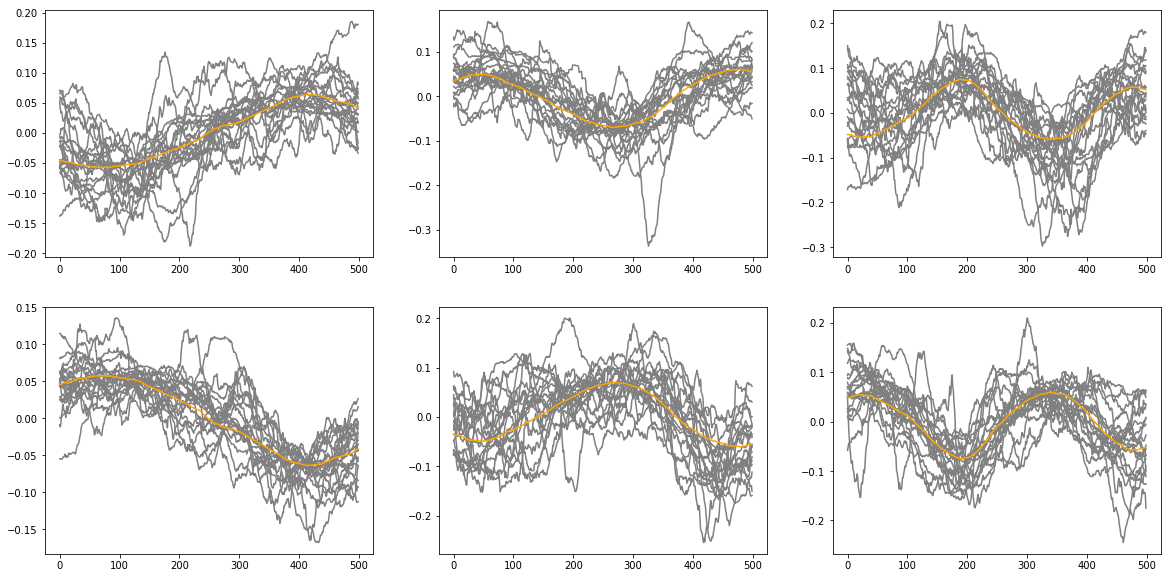

In [28]:
plot_svd_modes(data, v, w)

In [23]:
from sklearn.cluster import AgglomerativeClustering
def cluster(data, number_of_clusters):
    cluster = AgglomerativeClustering(n_clusters=number_of_clusters, linkage='ward')
    prediction = cluster.fit_predict(data)
    return prediction

In [24]:
def show_heirarchical_clustering(data, number_of_clusters, prediction):
    cluster_means = []
    fig, axes = plt.subplots(int((number_of_clusters-1)/3)+1, 3)
    fig.set_size_inches(20,10)
    for i in range(int((number_of_clusters-1)/3)+1):
        for j in range(3):
            if 3*i + j >= number_of_clusters:
                continue
            relevant_sentiments = np.where(prediction== 3*i + j)
            total = np.zeros(output_sentiment_length)
            for index in relevant_sentiments[0]:
                total += data[index]
            mean = total/len(relevant_sentiments[0])
            neighbors = nearest_neighbors(mean, data[relevant_sentiments[0]], 20)
            for neighbor in neighbors:
                if len(axes.shape)>1:
                    axes[i, j].plot(data[relevant_sentiments[0]][neighbor], 'gray')
                else:
                    axes[j].plot(data[relevant_sentiments[0]][neighbor], 'gray')
            if len(axes.shape)>1:
                axes[i, j].plot(mean, 'orange')
                axes[i, j].title.set_text(str(len(relevant_sentiments[0])))
            else:
                axes[j].plot(mean, 'orange')
                axes[j].title.set_text(str(len(relevant_sentiments[0])))
            cluster_means.append(mean)
    return cluster_means
    

In [25]:
number_of_clusters = 9
predictions = cluster(data, number_of_clusters)
cluster_means = show_heirarchical_clustering(data, number_of_clusters, predictions)

NameError: name 'data' is not defined

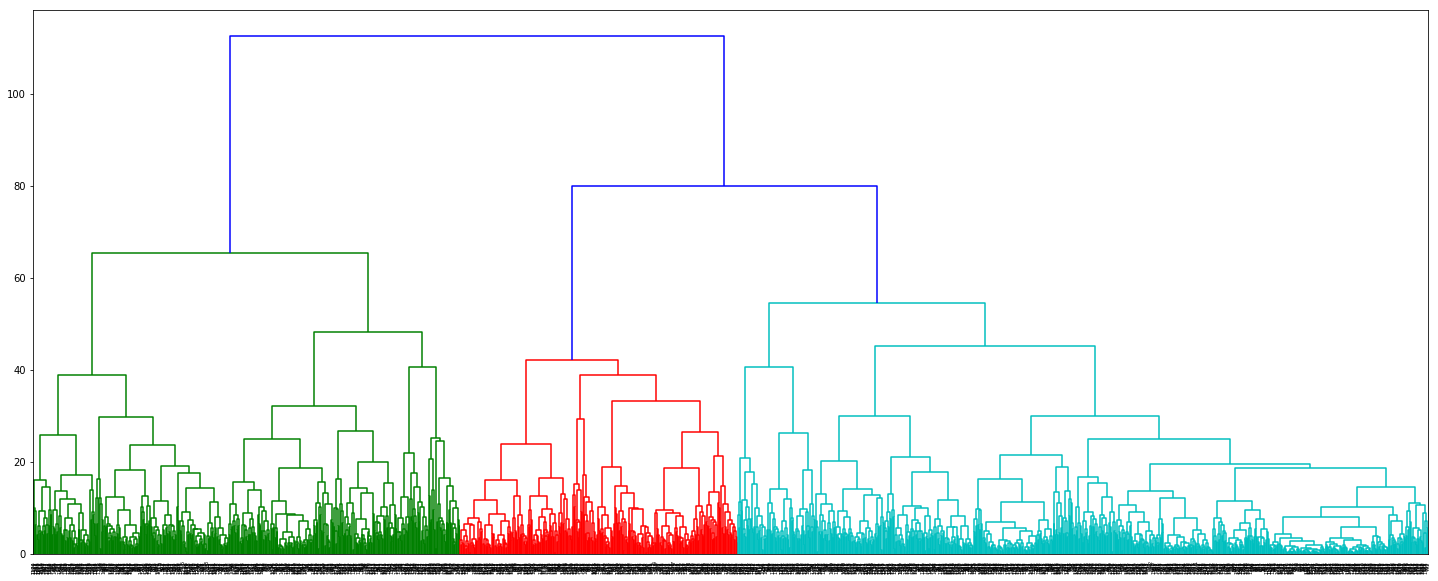

In [32]:
from scipy.cluster.hierarchy import dendrogram,linkage
fig = plt.figure(figsize=(25, 10))
fit = linkage(data,metric='euclidean',method='ward')
dn = dendrogram(fit)
plt.show()

In [26]:
def get_cluster_svd_correlation(w, predictions):
    modes = []
    for i in range(w.shape[0]):
        svd_mode = np.argmax(np.abs(w[i, :]))
        if np.sign(w[i, svd_mode]) < 0:
            modes.append(-svd_mode - 1)
        else:
            modes.append(svd_mode)
    color_map = np.zeros((6, number_of_clusters))
    for i in range(len(predictions)):
        if -3<=modes[i]<3:
            color_map[modes[i]+3, predictions[i]] += 1
    for i in range(color_map.shape[1]):
        color_map[:, i]/=np.sum(color_map[ :, i])
    print(color_map)
    plt.matshow(color_map, cmap=plt.get_cmap('Blues'))
    plt.show()
    return modes

[[0.01408451 0.03314917 0.15243902 0.69230769 0.01290323 0.13333333
  0.00787402 0.09174312 0.        ]
 [0.01408451 0.4198895  0.01829268 0.         0.07741935 0.14202899
  0.         0.59633028 0.        ]
 [0.90140845 0.41436464 0.82926829 0.         0.         0.35362319
  0.38582677 0.         0.        ]
 [0.         0.         0.         0.03846154 0.71612903 0.17101449
  0.00787402 0.31192661 0.06060606]
 [0.02816901 0.         0.         0.26923077 0.09677419 0.15652174
  0.40944882 0.         0.93939394]
 [0.04225352 0.13259669 0.         0.         0.09677419 0.04347826
  0.18897638 0.         0.        ]]


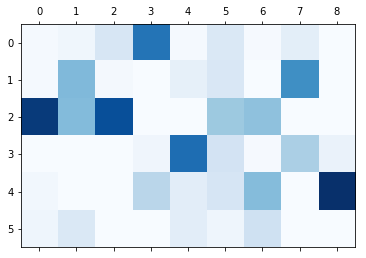

In [34]:
modes = get_cluster_svd_correlation(w, predictions)

In [35]:
#https://rubikscode.net/2018/08/27/implementing-self-organizing-maps-with-python-and-tensorflow/
from minisom import MiniSom
map_size = 8
som = MiniSom(map_size, map_size, 500)
som.train_random(data, 5000)
label_map = som.labels_map(data, modes)

<Figure size 432x288 with 0 Axes>

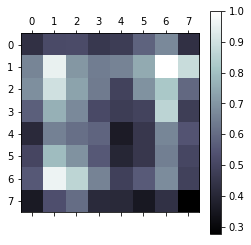

In [36]:
plt.bone()
plt.matshow(som.distance_map())
plt.colorbar()
plt.show()

In [27]:
def plot_clustering_som_correlation(map_size, label_map):
    fig, axes = plt.subplots(2, 3)
    for sub_plot in range(3):
        color_map = np.zeros((map_size, map_size))
        for i in range(color_map.shape[0]):
            for j in range(color_map.shape[1]):
                color_map[i][j] = label_map[(i, j)][sub_plot]
                axes[0, sub_plot].imshow(color_map, cmap=plt.get_cmap('Blues'))
        color_map = np.zeros((map_size, map_size))
        for i in range(color_map.shape[0]):
            for j in range(color_map.shape[1]):
                color_map[i][j] = label_map[(i, j)][-sub_plot-1]
                axes[1, sub_plot].imshow(color_map, cmap=plt.get_cmap('Blues'))
    plt.show()

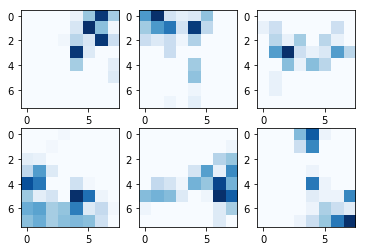

In [38]:
plot_clustering_som_correlation(map_size, label_map)

In [39]:
help(MiniSom)

Help on class MiniSom in module minisom:

class MiniSom(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5, decay_function=<function asymptotic_decay at 0x000001C076E0E378>, neighborhood_function='gaussian', random_seed=None)
 |      Initializes a Self Organizing Maps.
 |      
 |      A rule of thumb to set the size of the grid for a dimensionality
 |      reduction task is that it should contain 5*sqrt(N) neurons
 |      where N is the number of samples in the dataset to analyze.
 |      
 |      E.g. if your dataset has 150 samples, 5*sqrt(150) = 61.23
 |      hence a map 8-by-8 should perform well.
 |      
 |      Parameters
 |      ----------
 |      x : int
 |          x dimension of the SOM.
 |      
 |      y : int
 |          y dimension of the SOM.
 |      
 |      input_len : int
 |          Number of the elements of the vectors in input.
 |      
 |      sigma : float, optional (default=1.0)
 |          Spread o

In [28]:
import csv
import sys
movie_scripts = {}
sentiment_dict = get_sentiment_dict()
csv.field_size_limit(100000000)
with open(r'D:\university\NLP\movies-and-movie-scripts\moviedataset.csv', encoding='utf8') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    row_count = 0
    for row in csv_reader:
        if row_count > 0:
            lines = str.splitlines(row[-1])
            text= get_text(lines).split(' ')
            try:
                movie_scripts[int(row[0])] = TextData(row[3], hedonometer(sentiment_dict, text, output_sentiment_length, 1150, [3,7]), text)
            except:
                print('failed at ' + row[0])
        else:
            None
        row_count += 1
            
        

Not enough words to calculate sentiment: 1
failed at 26
Not enough words to calculate sentiment: 1
failed at 37
Not enough words to calculate sentiment: 1
failed at 51
Not enough words to calculate sentiment: 1
failed at 52
Not enough words to calculate sentiment: 1
failed at 64
Not enough words to calculate sentiment: 1
failed at 98
Not enough words to calculate sentiment: 1
failed at 101
Not enough words to calculate sentiment: 1
failed at 107
Not enough words to calculate sentiment: 1
failed at 109
Not enough words to calculate sentiment: 1
failed at 114
Not enough words to calculate sentiment: 1
failed at 123
Not enough words to calculate sentiment: 1
failed at 126
Not enough words to calculate sentiment: 1
failed at 127
Not enough words to calculate sentiment: 1
failed at 157
Not enough words to calculate sentiment: 1
failed at 158
Not enough words to calculate sentiment: 1
failed at 164
Not enough words to calculate sentiment: 1
failed at 184
Not enough words to calculate sentime

Not enough words to calculate sentiment: 1
failed at 1387
Not enough words to calculate sentiment: 1
failed at 1400
Not enough words to calculate sentiment: 1
failed at 1406
Not enough words to calculate sentiment: 1
failed at 1408
Not enough words to calculate sentiment: 1
failed at 1427
Not enough words to calculate sentiment: 1
failed at 1432
Not enough words to calculate sentiment: 1
failed at 1437
Not enough words to calculate sentiment: 1
failed at 1445
Not enough words to calculate sentiment: 1
failed at 1446
Not enough words to calculate sentiment: 1
failed at 1465
Not enough words to calculate sentiment: 1
failed at 1469
Not enough words to calculate sentiment: 1
failed at 1470
Not enough words to calculate sentiment: 1
failed at 1471
Not enough words to calculate sentiment: 1
failed at 1478
Not enough words to calculate sentiment: 1
failed at 1480
Not enough words to calculate sentiment: 1
failed at 1493
Not enough words to calculate sentiment: 1
failed at 1494
Not enough wor

Not enough words to calculate sentiment: 1
failed at 2151
Not enough words to calculate sentiment: 1
failed at 2164
Not enough words to calculate sentiment: 1
failed at 2165
Not enough words to calculate sentiment: 1
failed at 2166
Not enough words to calculate sentiment: 1
failed at 2167
Not enough words to calculate sentiment: 1
failed at 2169
Not enough words to calculate sentiment: 1
failed at 2171
Not enough words to calculate sentiment: 1
failed at 2172
Not enough words to calculate sentiment: 1
failed at 2173
Not enough words to calculate sentiment: 1
failed at 2174
Not enough words to calculate sentiment: 1
failed at 2175
Not enough words to calculate sentiment: 1
failed at 2176
Not enough words to calculate sentiment: 1
failed at 2177
Not enough words to calculate sentiment: 1
failed at 2178
Not enough words to calculate sentiment: 1
failed at 2179
Not enough words to calculate sentiment: 1
failed at 2180
Not enough words to calculate sentiment: 1
failed at 2209
Not enough wor

Not enough words to calculate sentiment: 1
failed at 2944
Not enough words to calculate sentiment: 1
failed at 2946
Not enough words to calculate sentiment: 1
failed at 2947
Not enough words to calculate sentiment: 1
failed at 2948
Not enough words to calculate sentiment: 1
failed at 2957
Not enough words to calculate sentiment: 455
failed at 2989
Not enough words to calculate sentiment: 310
failed at 2992
Not enough words to calculate sentiment: 1
failed at 3002
Not enough words to calculate sentiment: 1
failed at 3005
Not enough words to calculate sentiment: 1
failed at 3016
Not enough words to calculate sentiment: 1
failed at 3017
Not enough words to calculate sentiment: 1
failed at 3018
Not enough words to calculate sentiment: 355
failed at 3065
Not enough words to calculate sentiment: 1
failed at 3074
Not enough words to calculate sentiment: 1
failed at 3078
Not enough words to calculate sentiment: 1
failed at 3095
Not enough words to calculate sentiment: 1
failed at 3109
Not enou

Not enough words to calculate sentiment: 1
failed at 3804
Not enough words to calculate sentiment: 1
failed at 3809
Not enough words to calculate sentiment: 1
failed at 3819
Not enough words to calculate sentiment: 1
failed at 3822
Not enough words to calculate sentiment: 1
failed at 3827
Not enough words to calculate sentiment: 1
failed at 3842
Not enough words to calculate sentiment: 1
failed at 3844
Not enough words to calculate sentiment: 1
failed at 3846
Not enough words to calculate sentiment: 1
failed at 3847
Not enough words to calculate sentiment: 1
failed at 3849
Not enough words to calculate sentiment: 1
failed at 3850
Not enough words to calculate sentiment: 1
failed at 3851
Not enough words to calculate sentiment: 1
failed at 3852
Not enough words to calculate sentiment: 1
failed at 3853
Not enough words to calculate sentiment: 1
failed at 3854
Not enough words to calculate sentiment: 1
failed at 3855
Not enough words to calculate sentiment: 1
failed at 3856
Not enough wor

In [41]:
print(np.mean([len(book.text) for book in texts.values()]))
print(np.mean([len(movie.text) for movie in movie_scripts.values()]))

74395.05179768434
8554.131881427707


In [37]:
len(movie_scripts)

3306

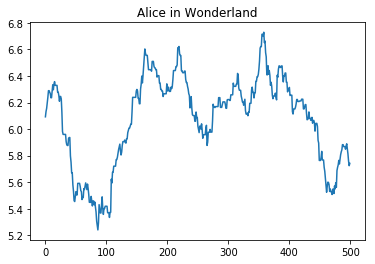

In [43]:
movie_index = 757
plt.plot(movie_scripts[movie_index].sentiment)
plt.title(movie_scripts[movie_index].name)
plt.show()

In [44]:
[(id,movie_scripts[id].name) for id in movie_scripts]

[(0, 'The Hours'),
 (1, 'A.I. Artificial Intelligence'),
 (2, 'The Bridges of Madison County'),
 (3, 'The Devil Wears Prada'),
 (4, 'The House of the Spirits'),
 (5, 'Prime'),
 (6, 'Fantastic Mr. Fox'),
 (7, 'Adaptation.'),
 (8, 'Rendition'),
 (9, 'Dancing at Lughnasa'),
 (10, 'Evening'),
 (11, "It's Complicated"),
 (12, 'Mamma Mia!'),
 (13, "Lemony Snicket's A Series of Unfortunate Events"),
 (14, 'Julie & Julia'),
 (15, 'Defending Your Life'),
 (16, 'The River Wild'),
 (17, 'Death Becomes Her'),
 (18, 'Music of the Heart'),
 (19, 'A Prairie Home Companion'),
 (20, '...First Do No Harm'),
 (21, "Marvin's Room"),
 (22, 'The Ant Bully'),
 (23, 'Doubt'),
 (24, 'The Manchurian Candidate'),
 (25, 'Before and After'),
 (27, 'Dark Matter'),
 (28, 'One True Thing'),
 (29, 'Hope Springs'),
 (30, 'August: Osage County'),
 (31, 'Into the Woods'),
 (32, 'The Giver'),
 (33, 'The Homesman'),
 (34, 'Florence Foster Jenkins'),
 (35, 'Ricki and the Flash'),
 (36, 'Stuck on You'),
 (38, 'Mars Attacks!'

In [45]:
order_mapping2 = dict(zip(movie_scripts.keys(), list(range(len(movie_scripts)))))
reverse_order_mapping2 = dict(zip(list(range(len(movie_scripts))), movie_scripts.keys()))
data2 = np.array([movie.sentiment-np.mean(movie.sentiment) for movie in movie_scripts.values()])

In [46]:
u2, sigma2, v2 = svd_analysis(data2)
w2= u2 * sigma2 # mode coefficients

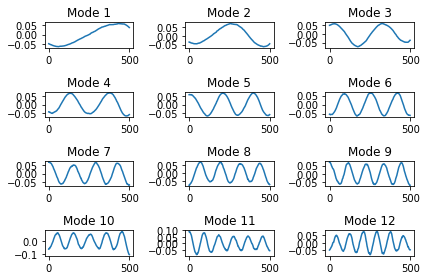

In [47]:
plot_svd_basis(v2)

In [48]:
np.sum(sigma2[:12]**2)/np.sum(sigma2**2)#explained variance

0.92153241305347

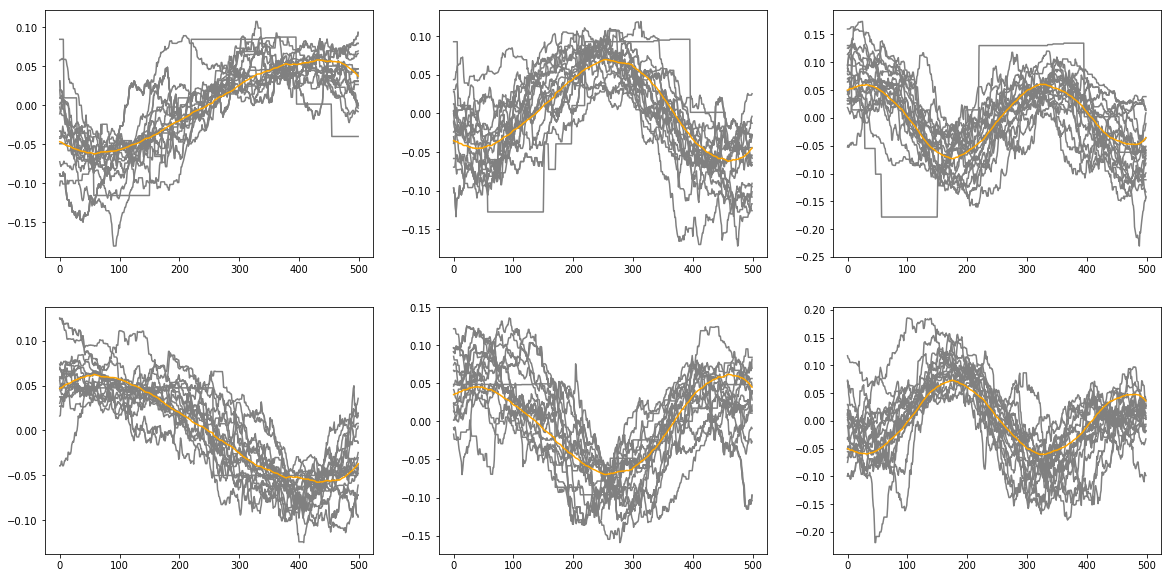

In [49]:
plot_svd_modes(data2, v2, w2)

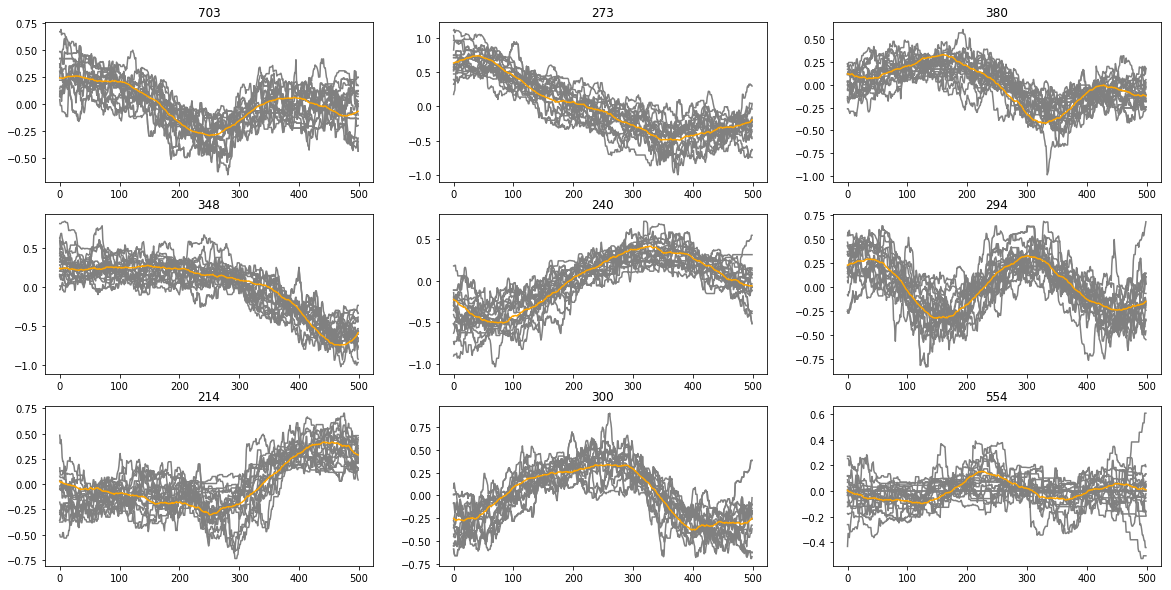

In [50]:
number_of_clusters = 9
movie_predictions = cluster(data2, number_of_clusters)
cluster_means_movies = show_heirarchical_clustering(data2, number_of_clusters, movie_predictions)

[[0.03010753 0.         0.41295547 0.         0.02898551 0.
  0.09497207 0.06896552 0.2480916 ]
 [0.47311828 0.13360324 0.03643725 0.         0.         0.
  0.39664804 0.         0.10687023]
 [0.35053763 0.80161943 0.54251012 0.69902913 0.         0.15
  0.         0.14655172 0.09160305]
 [0.00645161 0.         0.00404858 0.         0.63285024 0.02272727
  0.41899441 0.         0.19847328]
 [0.01935484 0.00809717 0.         0.21035599 0.29468599 0.17272727
  0.         0.78448276 0.23282443]
 [0.12043011 0.05668016 0.00404858 0.09061489 0.04347826 0.65454545
  0.08938547 0.         0.1221374 ]]


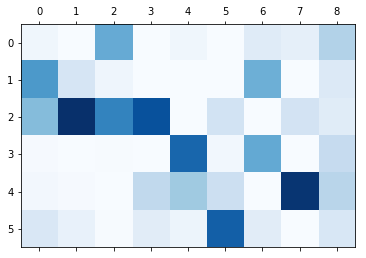

In [51]:
modes_movies = get_cluster_svd_correlation(w2, movie_predictions)

In [52]:
#https://rubikscode.net/2018/08/27/implementing-self-organizing-maps-with-python-and-tensorflow/
from minisom import MiniSom
map_size = 8
som = MiniSom(map_size, map_size, 500)
som.train_random(data2, 5000)
label_map_movies = som.labels_map(data2, modes_movies)

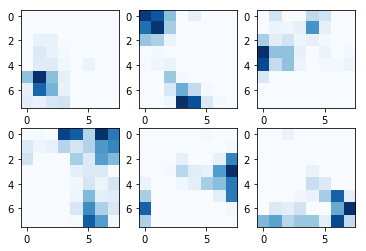

In [53]:
plot_clustering_som_correlation(map_size, label_map_movies)

In [54]:
import random
word_salad = {}
for movie_id in movie_scripts:
    movie = movie_scripts[movie_id]
    shuffled_text = movie.text.copy()
    random.shuffle(shuffled_text)
    word_salad[movie_id] = TextData(movie.name, hedonometer(sentiment_dict, shuffled_text, output_sentiment_length, 1150, [3,7]), shuffled_text)
order_mapping_salad = dict(zip(word_salad.keys(), list(range(len(word_salad)))))
reverse_order_mapping_salad = dict(zip(list(range(len(word_salad))), word_salad.keys()))
data_salad = np.array([movie.sentiment-np.mean(movie.sentiment) for movie in word_salad.values()])
u_salad, sigma_salad, v_salad = svd_analysis(data_salad)
w_salad= u_salad * sigma_salad # mode coefficients

In [55]:
np.sum(sigma_salad[:12]**2)/np.sum(sigma_salad**2)

0.8826496742134412

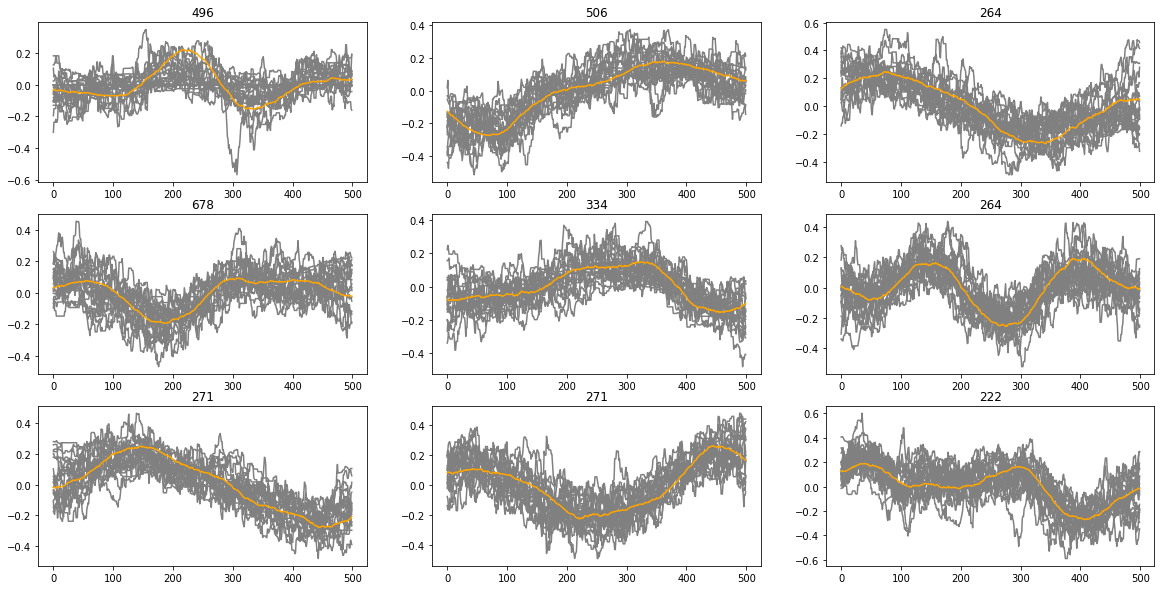

In [56]:
movie_predictions_salad = cluster(data_salad, number_of_clusters)
cluster_means_movies_salad = show_heirarchical_clustering(data_salad, number_of_clusters, movie_predictions_salad)

[[0.         0.01822917 0.00833333 0.42091153 0.25471698 0.00813008
  0.03317536 0.00454545 0.25984252]
 [0.33684211 0.18489583 0.         0.01608579 0.6509434  0.
  0.16113744 0.         0.23622047]
 [0.16842105 0.         0.56666667 0.02144772 0.03773585 0.06504065
  0.76303318 0.01363636 0.44094488]
 [0.03859649 0.71614583 0.         0.31099196 0.03301887 0.15447154
  0.         0.06818182 0.        ]
 [0.05263158 0.         0.2125     0.22252011 0.00471698 0.3495935
  0.         0.78636364 0.06299213]
 [0.40350877 0.08072917 0.2125     0.0080429  0.01886792 0.42276423
  0.04265403 0.12727273 0.        ]]


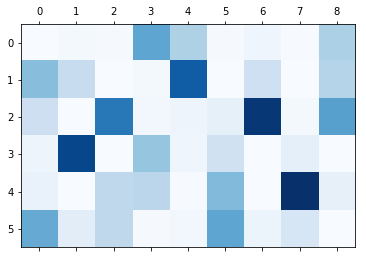

In [57]:
modes_movies_salad = get_cluster_svd_correlation(w_salad, movie_predictions_salad)

In [72]:
def weighted_random(dictionary):
    total_values = np.sum(list(dictionary.values()))
    random_value = random.random()
    total = 0
    for key, value in dictionary.items():
        total += value
        if random_value*total_values <= total:
            return key

In [73]:
from collections import defaultdict, Counter
def generate_ngram_random(text, n):
    text = [word.lower() for word in text]
    choice_dict = defaultdict(lambda: Counter())
    for i in range(len(text)-n-1):
        choice_dict[tuple(text[i:i+n])][text[i+n]]+=1
    output_text = []
    for i in range(n):
        output_text.append(random.choice(text))
    while len(output_text) < len(text):
        last_words = tuple(output_text[-n:])
        if last_words in choice_dict:
            output_text.append(weighted_random(choice_dict[last_words]))
        else:
            output_text.append(random.choice(text))
    return output_text
        

In [74]:
import random
word_2gram = {}
for movie_id in movie_scripts:
    movie = movie_scripts[movie_id]
    shuffled_text = generate_ngram_random(movie.text, 2)
    word_2gram[movie_id] = TextData(movie.name, hedonometer(sentiment_dict, shuffled_text, output_sentiment_length, 1150, [3,7]), shuffled_text)
order_mapping_2gram = dict(zip(word_2gram.keys(), list(range(len(word_2gram)))))
reverse_order_mapping_2gram = dict(zip(list(range(len(word_2gram))), word_2gram.keys()))
data_2gram = np.array([movie.sentiment-np.mean(movie.sentiment) for movie in word_2gram.values()])
u_2gram, sigma_2gram, v_2gram = svd_analysis(data_2gram)
w_2gram= u_2gram * sigma_2gram # mode coefficients

In [75]:
np.sum(sigma_2gram[:12]**2)/np.sum(sigma_2gram**2)

0.8881150462360203

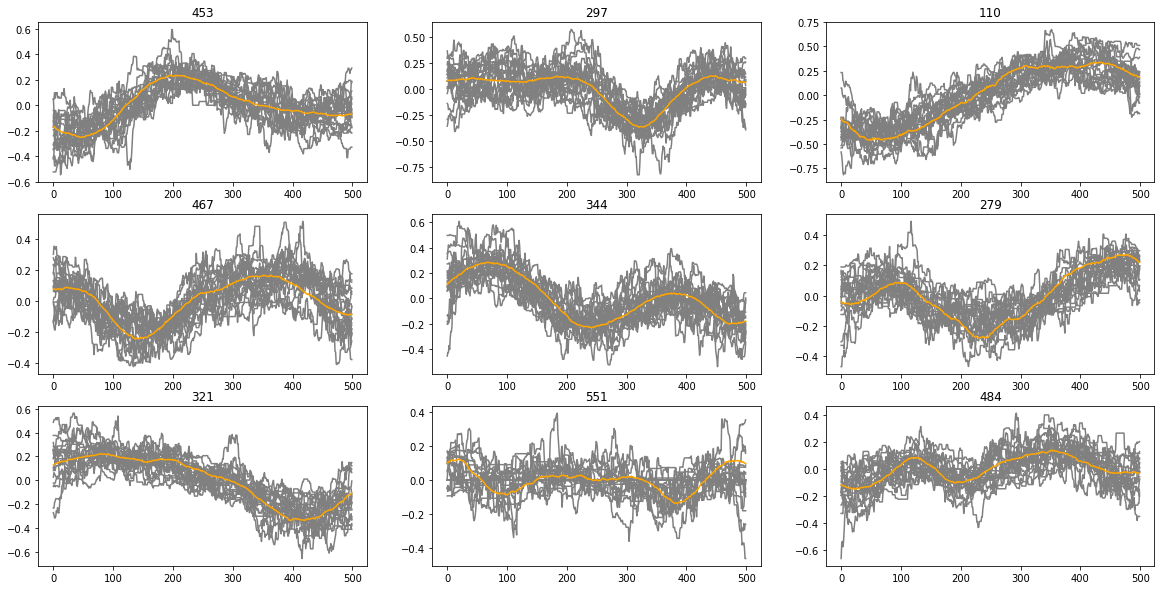

In [76]:
movie_predictions_2gram = cluster(data_2gram, number_of_clusters)
cluster_means_movies_2gram = show_heirarchical_clustering(data_2gram, number_of_clusters, movie_predictions_2gram)

[[0.00554017 0.00555556 0.         0.39009288 0.28813559 0.
  0.03436426 0.07407407 0.1509434 ]
 [0.62603878 0.         0.04807692 0.10216718 0.00423729 0.
  0.06872852 0.16931217 0.24528302]
 [0.02493075 0.33333333 0.         0.0247678  0.33474576 0.01382488
  0.88316151 0.23809524 0.01886792]
 [0.04432133 0.         0.93269231 0.39318885 0.00423729 0.20737327
  0.         0.18518519 0.46226415]
 [0.         0.28888889 0.         0.08978328 0.36864407 0.66820276
  0.00687285 0.15343915 0.08490566]
 [0.29916898 0.37222222 0.01923077 0.         0.         0.11059908
  0.00687285 0.17989418 0.03773585]]


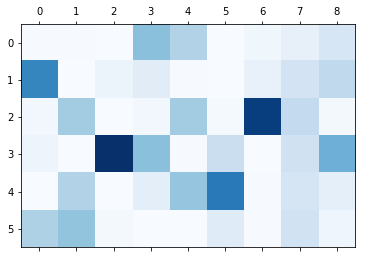

In [77]:
modes_movies_2gram = get_cluster_svd_correlation(w_2gram, movie_predictions_2gram)